# 머신러닝 모델 기반 다른 유저들의 승률 예측 분석

<목차>

1. 개요

2. EDA

3. Feature Engineering

4. 모델 개발

5. 모델 평가

---
---

## 개요

### 1. 목적
- 승리 예측 모델 개발 및 특성 중요도 분석
    - 승리에 주요하게 영향을 미치는 특성을 파악하기 위함

### 2. 데이터 설명
- FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
- 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
- 매치ID 중복 데이터 존재 > 경기 기준이 아닌 골 기준으로 ROW가 집계됨(득점 좌표 데이터 활용하기 위함)
- API를 통해 호출한 데이터를 가공하여 다운 받은 CSV 파일을 호출한다.

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [3]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

#### ㄴ 데이터 호출

In [4]:
# 데이터 프레임 생성
match_df_1 = pd.read_csv('250321_recent_matches.csv', encoding='utf-8-sig')
match_df_2 = pd.read_csv('250323_recent_matches.csv', encoding='utf-8-sig')

In [5]:
# 데이터 프레임 확인
match_df_1.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,possession,averageRating,dribble,cornerKick,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67dcffbaae8e1ee379b6f4e1,2025-03-21T05:58:33,50,453a4a0d3aabe1d5021cbf05e0ec64b1,뼈있는한마디,승,80,3.92778,17,0,...,139,0.942331,0.516820,3,1,802190045,False,-1,False,True
1,67dcffbaae8e1ee379b6f4e1,2025-03-21T05:58:33,50,453a4a0d3aabe1d5021cbf05e0ec64b1,뼈있는한마디,승,80,3.92778,17,0,...,543,0.938039,0.468086,2,1,216037576,True,813268513,False,True
2,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,476,0.790404,0.625788,1,1,291213648,True,832202126,False,False
3,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,586,0.823813,0.704928,2,2,831200104,True,814188942,False,False
4,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,897,0.845700,0.454505,2,3,832202126,True,289177003,False,True


In [6]:
# 데이터 프레임 확인
match_df_2.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,possession,averageRating,dribble,cornerKick,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67dfdb2cffc7b2223341cf28,2025-03-23T09:59:42,50,11e680208c9d26a251023337fcf4e870,망고욱현,승,62,4.38333,4,0,...,232,0.906021,0.670537,2,3,291240452,True,829227232,False,True
1,67dfdb1a8a1ee8788f3e6130,2025-03-23T09:59:03,50,5403c8a5423a2c08696f68a32bc816c6,찌랭이0327,승,44,3.98889,5,1,...,573,0.839968,0.387843,2,3,832256630,True,291240709,False,False
2,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,475,0.783291,0.395553,4,2,826225539,False,-1,False,False
3,67dfdb17e795d740a68bdf08,2025-03-23T09:59:50,50,7e09a42b042a3ca88ba0d8214c61fc79,구단주댄스바,패,48,3.49444,7,1,...,135,0.908727,0.547382,1,1,826225539,True,270243702,False,True
4,67dfdaea8f28057e623fbaf9,2025-03-23T09:58:53,50,62ce1ea7553b9306f327702dfeaa0ba9,JEON영진,패,60,3.71111,10,0,...,490,0.928970,0.413836,6,1,832194765,True,825028130,False,True


- 두 데이터 프레임 병합
    - 각 날짜에 최근 100경기를 API로 호출했으나 몇 경기에서 error 코드가 발생해 집계가 되지 않는 문제 발생
    - 최대한 많은 모수 확보를 위해 해당 데이터 제외하고 나머지 데이터들 호출

In [8]:
# 데이터 병합
match_df = pd.concat([match_df_1,match_df_2], axis=0, ignore_index=True)
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,possession,averageRating,dribble,cornerKick,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67dcffbaae8e1ee379b6f4e1,2025-03-21T05:58:33,50,453a4a0d3aabe1d5021cbf05e0ec64b1,뼈있는한마디,승,80,3.92778,17,0,...,139,0.942331,0.516820,3,1,802190045,False,-1,False,True
1,67dcffbaae8e1ee379b6f4e1,2025-03-21T05:58:33,50,453a4a0d3aabe1d5021cbf05e0ec64b1,뼈있는한마디,승,80,3.92778,17,0,...,543,0.938039,0.468086,2,1,216037576,True,813268513,False,True
2,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,476,0.790404,0.625788,1,1,291213648,True,832202126,False,False
3,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,586,0.823813,0.704928,2,2,831200104,True,814188942,False,False
4,67dcffae2e1b1f533f29e9db,2025-03-21T05:59:32,50,b414a0e71a4e670f762b72a914b17229,회기동,승,70,4.13333,12,2,...,897,0.845700,0.454505,2,3,832202126,True,289177003,False,True


---

## EDA

### 1. 데이터 확인

In [9]:
# 데이터 크기 확인
match_df.shape

(258, 38)

In [ ]:
# 기술 통계 분석
match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,258,69,67dcfe848132af720225a71d,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,258,66,2025-03-21T05:59:27,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,258.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,258,86,ea2d5ad3cada75a6037b52299e6c1242,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,258,86,1번키커실축,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,258,2,승,184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
possession,258.0,NaN,NaN,NaN,55.228682,10.247807,36.0,48.0,55.0,61.0,100.0
averageRating,258.0,NaN,NaN,NaN,4.098062,0.512252,2.94444,3.71111,4.27222,4.50556,5.25556
dribble,258.0,NaN,NaN,NaN,25.546512,14.307346,3.0,14.0,25.0,35.0,63.0
cornerKick,258.0,NaN,NaN,NaN,0.848837,1.13162,0.0,0.0,0.0,1.0,5.0


In [14]:
# 데이터 정보 확인
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              258 non-null    object 
 1   matchDate            258 non-null    object 
 2   matchType            258 non-null    int64  
 3   ouid                 258 non-null    object 
 4   nickname             258 non-null    object 
 5   matchResult          258 non-null    object 
 6   possession           258 non-null    int64  
 7   averageRating        258 non-null    float64
 8   dribble              258 non-null    int64  
 9   cornerKick           258 non-null    int64  
 10  offsideCount         258 non-null    int64  
 11  shootTotal           258 non-null    int64  
 12  effectiveShootTotal  258 non-null    int64  
 13  goalTotal            258 non-null    int64  
 14  shootPenaltyKick     258 non-null    int64  
 15  goalPenaltyKick      258 non-null    int

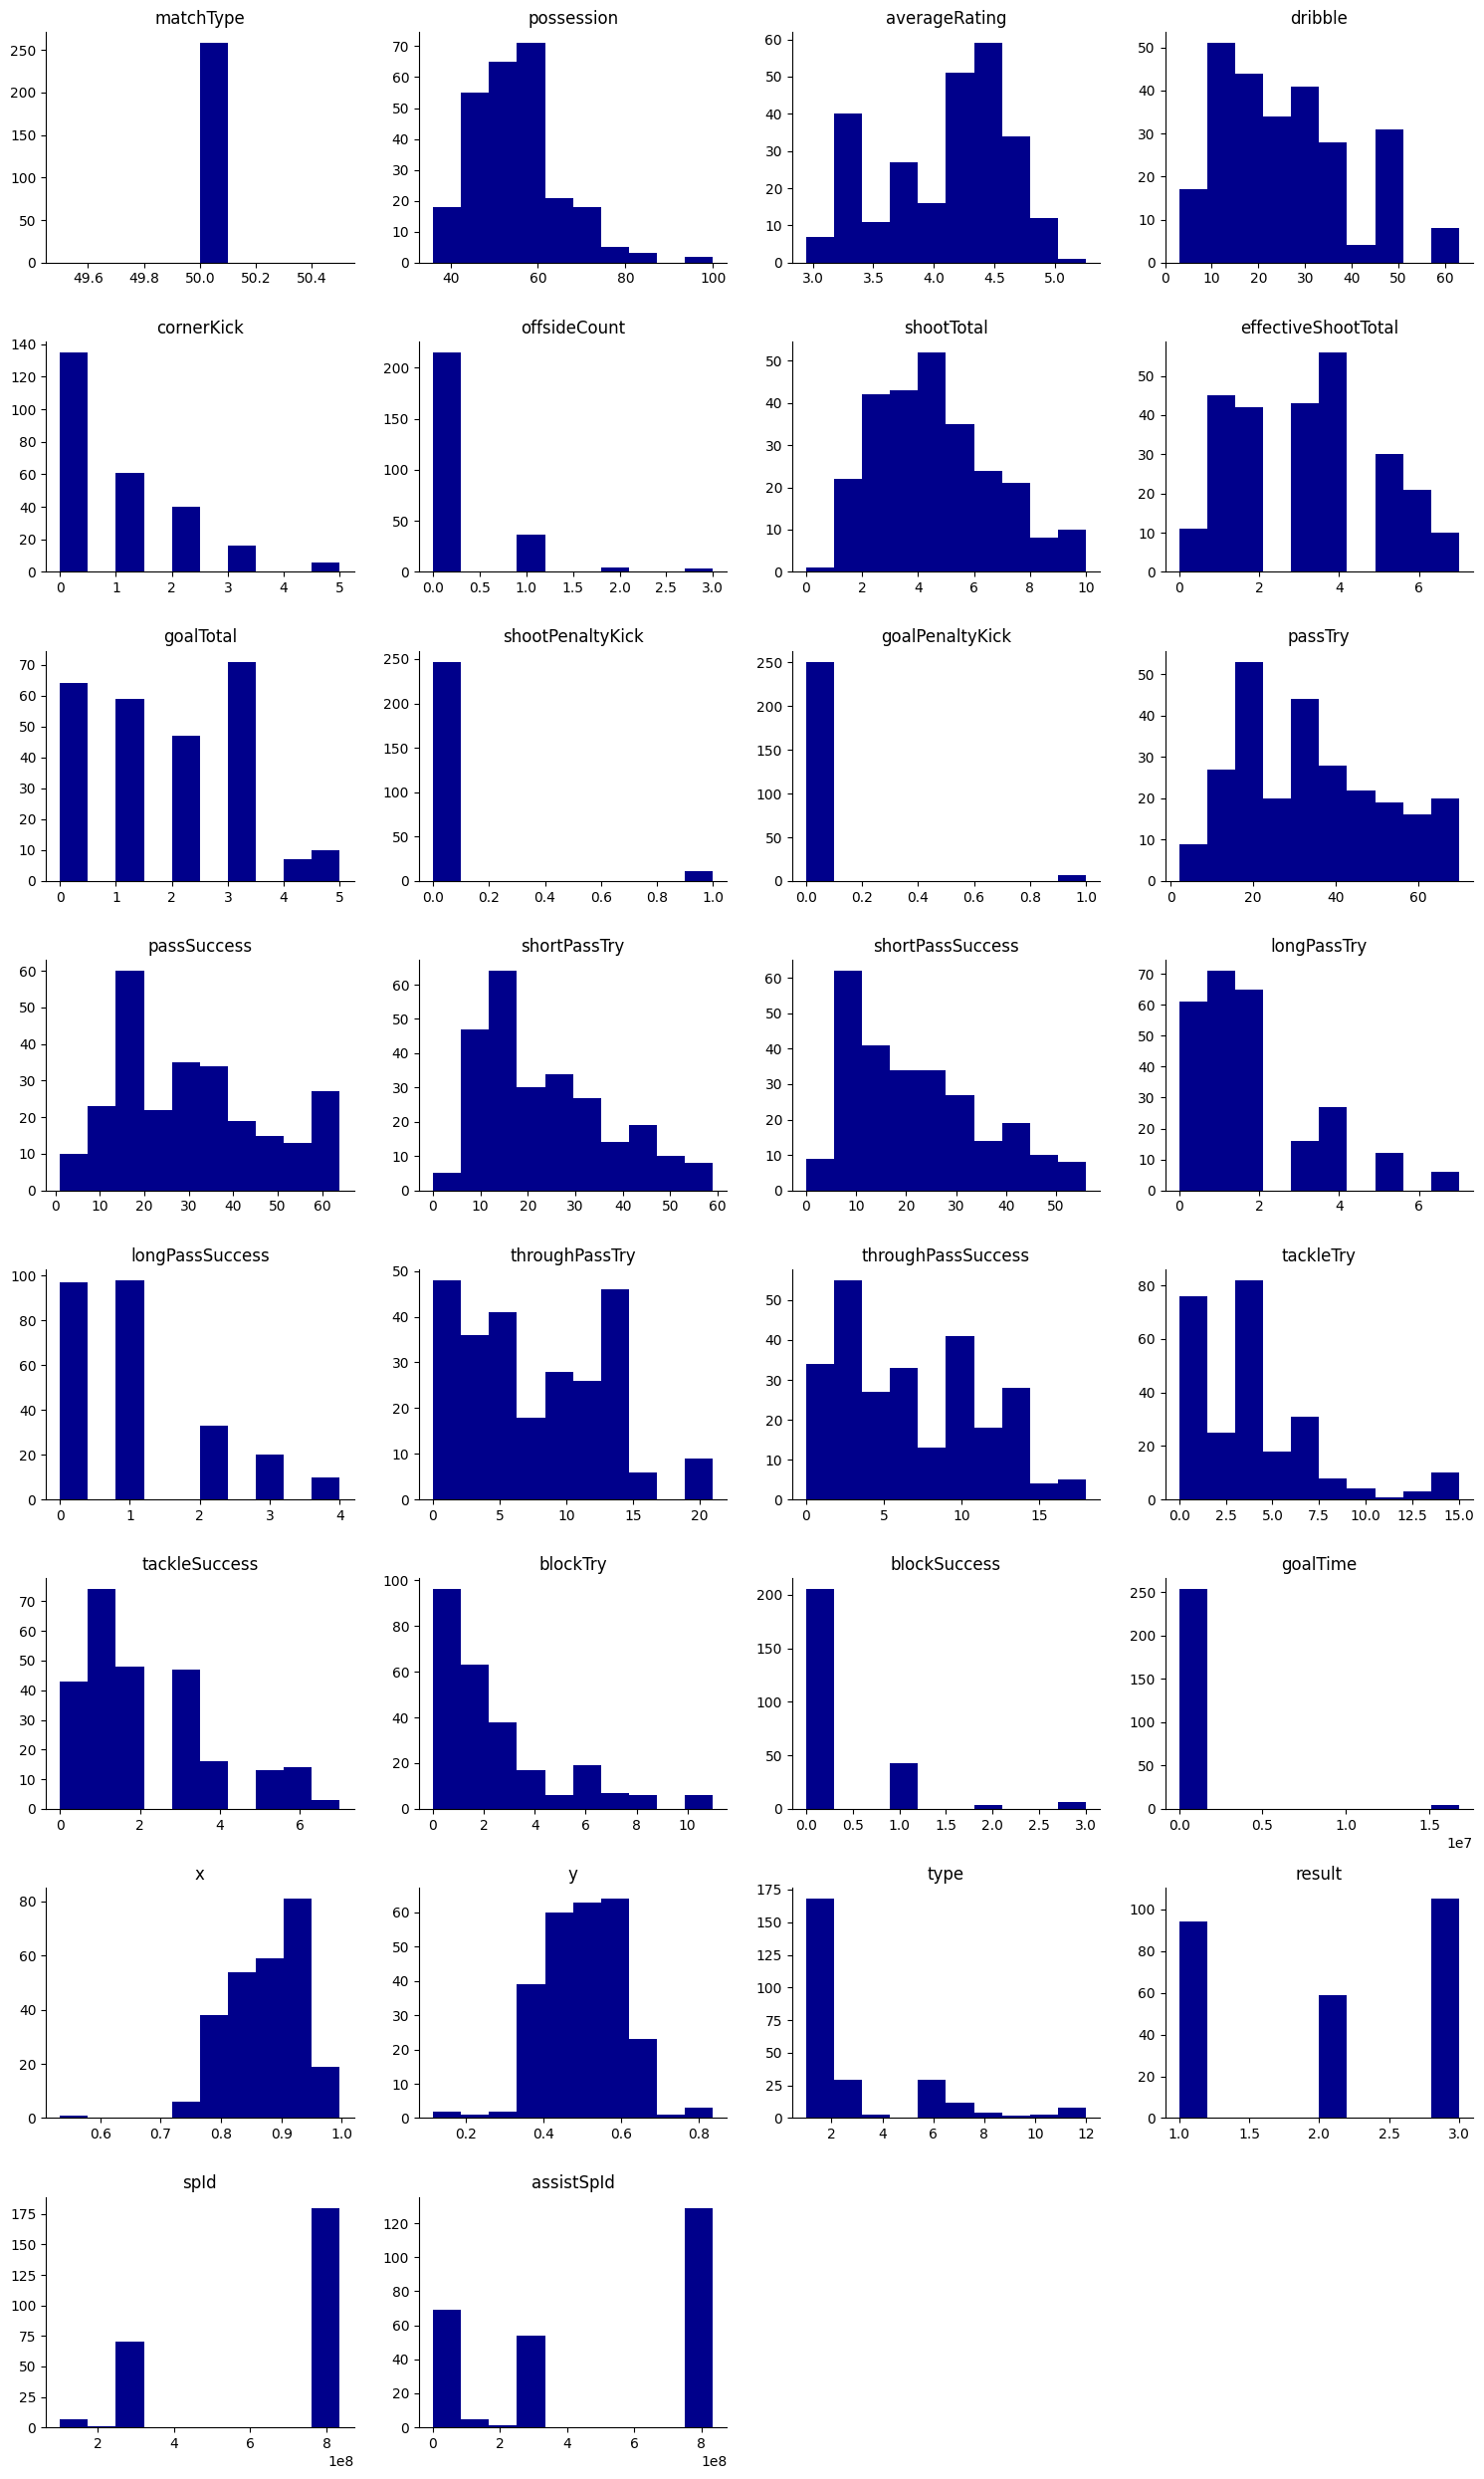

In [20]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(8, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- spId, assistSpId는 선수 고유 ID
- goalTime의 max값이 3분위수와 차이가 많이 난다.
- 연속형 변수 중, goalTime을 제외하고는 특별한 이상치가 기술 통계량에서는 확인되지 않는다.
- matchResult는 승리 여부로, 범주형 변수이자 머신러닝 모델의 종속변수가 된다.(이진수가 아닌 '승','패'로 object 타입으로 저장되어 있다.)
- Try와 Success 데이터를 통해 성공확률을 도출할 수 있다.(ex. 패스, 숏패스, 롱패스, 스루패스, 태클 등)

### 2. 데이터 전처리

#### ㄴ 결측값 처리

#### ㄴ 중복값 처리

#### ㄴ 이상치 처리

#### ㄴ 데이터 인코딩